## Notebook 03: Linear Regression and Gradient Descent
### CBE 512. Machine Learning in Chemical Science and Engineering.

&#169; Princeton University

# **Concepts with Linear Regression**
Many of the important concepts in supervised machine learning can be appreciated by a solid understanding of linear regression, which we all probably encountered early on -- like elementary school. We are going to work through a linear regression task in a fashion  to appreciate many of the basic mechanics that underlie deep learning.

To start, we will pull a dataset generated in [a recent paper from Prof. Webb's group](https://pubs.rsc.org/en/content/articlelanding/2022/me/d1me00160d/unauth) that explores the use of machine learning to predict polymer properties. The label  that we extract (and our target for prediction) will be the radius of gyration ($R_g$), which provides a measure of an object's size, for some simulated intrinsically disordered proteins.

A well known result from polymer physics is that [$R_g \propto M^{0.5}$](https://en.wikipedia.org/wiki/Ideal_chain), where $M$ is the number of statistically uncorrelated sub-units in the polymer; the same result arises in the context of diffusion/random walks.

In the following, we will examine how well the data on $R_g$ can be described by a simple linear model with $N^{0.5}$ as our input feature ($N$ will be the number of residues in the protein, which we do not generally expect to be a statistically uncorrelated sub-unit).

Run the cell below to load the modules that were used by Prof. Webb to engage in this activity.

In [1]:
# Modules used by Prof. Webb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import random
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

## **Grabbing data from a remote source online**

In the following cell, we show how to grab some data in reasonable format from online. `pandas` provides a convenient way to parse `.csv` files. Simple text files can be processed using standard I/O commands.



In [2]:
url_for_labels    = "https://raw.githubusercontent.com/webbtheosim/featurization/main/Dataset_A/labels.csv"
url_for_sequences = "https://raw.githubusercontent.com/webbtheosim/featurization/main/Dataset_A/sequences.txt"
idpdata = pd.read_csv(
    url_for_labels
)

y = idpdata['ROG (A)'].to_numpy()/10.     # these are now labels
seqs  = [line.strip().split() for line in urllib.request.urlopen(url_for_sequences)]
X     = np.array([len(seq) for seq in seqs])**0.5   # these are features

idpdata.head()

,ROG (A),CV (J/K),TAUS (fs)
0,11.725914,0.444604,36585.162
1,11.912079,0.370302,40234.011
2,11.375047,0.399939,38123.675
3,11.457038,0.407542,34174.561
4,11.509964,0.449730,34279.740


## **Plotting data**

The cell below creates a function that will make a relatively standard but reasonably aesthetic plot. Because we are going to make a lot of these plots, we create a function instead of hard-coding the single instance, requiring many copy/pastes!

Go ahead and play around with some options and customize it to your liking. You'll notice the use of `rcParams`, which provides access to a large number of configurable aspects of plots by default; you can view these [here](https://matplotlib.org/stable/tutorials/introductory/customizing.html).




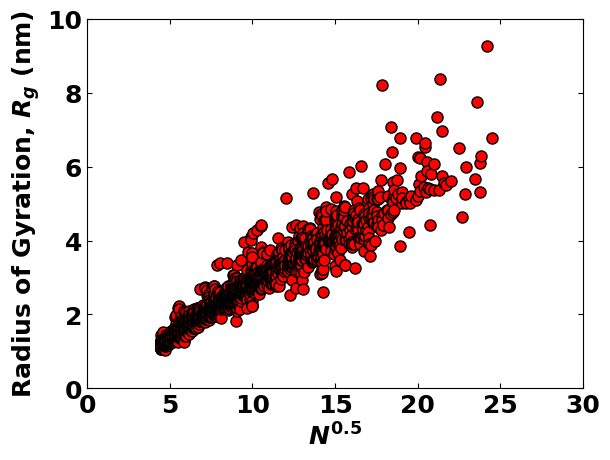

In [3]:
# global specifications on plots
plt.rcParams.update({'font.size': 18,
                     'font.weight' : 'bold',
                     'axes.labelweight': 'bold'})

def plot_raw_data(x,y):
  plt.plot(x, y,marker='o',linestyle="",markersize=8,\
           color='r',markeredgecolor='k')
  plt.ylabel("Radius of Gyration, $R_g$ (nm)")
  plt.xlabel("$N^{0.5}$")
  plt.xlim(0,30)
  plt.ylim(0,10)
  ax = plt.gca()
  ax.tick_params(direction='in')
  ax.yaxis.set_ticks_position('both')
  ax.xaxis.set_ticks_position('both')
  return ax

ax = plot_raw_data(X,y)


## **Examining a human hypothesis**
At first glance, it certainly seems that there is reasonable linear correlation between our input and labels.

We are going to consider a function of the form

$$R_g = \theta_0 + \theta_1 N^{0.5}$$

Can you look at the plot to "guess" values of these parameters? Complete the cell below and explore some "hypotheses".

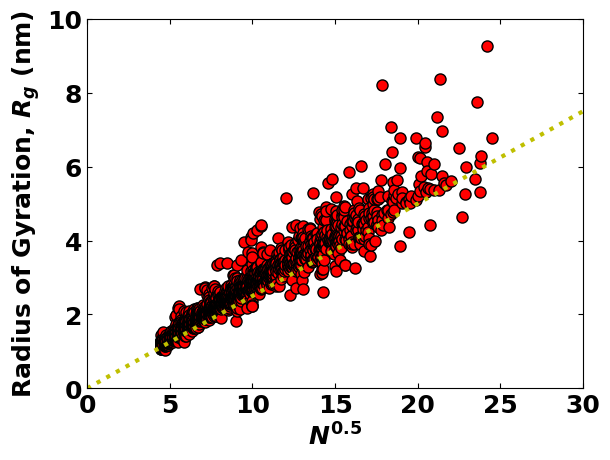

r2 = 0.884, MSE = 0.147, MAE = 0.254


In [7]:
# basic set up
Nmax = 900
xline= np.array(range(Nmax+1))**0.5
f    = lambda x, th: th[0] + th[1]*x

# fill in parameters
thetas = np.array([[0,.25]]).T # this maps to a 2x1

# make predictions using function
yline = f(xline,thetas)

# examine hypothesis
ax = plot_raw_data(X,y)
ax.plot(xline,yline,color='y',linewidth=3,linestyle=':')
plt.show()

# make predictions from features and compute evaluation metrics
yhat  = f(X,thetas)
r2    = r2_score(y,yhat)
rmse  = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("r2 = {:>5.3f}, MSE = {:>5.3f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

## **More formal optimization**
Probably your human-intuited fit yields a pretty darn good description of the data, but we'll try to do better.

The ``training'' of neural networks is really about *optimization* where the objective is to minimze a *loss* function that describes a disparity between the model predictions and the ground truth of some set of labels.

When we first encounter linear regression, our optimization is usually in the `least-squares' sense; that is, our loss function is the mean-squared error over our observations. The problem of linear least-squares regression can be ``exactly'' solved using techniques from linear algebra.
While that is not so much the domain of machine learning, let's see what answer we get via this approach to gain some expectation/intuition for the parameters.

## **Linear algebraic solution**
If run for enough iterations, the solution obtained from gradient descent should outperform our human-intuited estimated model, even if just slightly. Because this is least-squares linear regression, we can also compare our solution with that obtained via linear algebra.

In [9]:
N = len(y)
M = 2
A = np.ones((N,M))
A[:,1] = X[:]
thetaOpt = np.linalg.inv(A.T@A)@A.T@y # explicit solution for non-square matrix
#thetaOpt  = np.linalg.pinv(A)@y       # hiding the math through pinv (Penrose Inverse)
yhat  = f(X,thetaOpt)
r2    = r2_score(y,yhat)
mse   = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("theta_0 = {:>8.4f}".format(thetaOpt[0]))
print("theta_1 = {:>8.4f}".format(thetaOpt[1]))
print("r2 = {:>5.3f}, MSE = {:>8.5f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

theta_0 =  -0.0384
theta_1 =   0.2827
r2 = 0.941, MSE =  0.14733, MAE = 0.152


# **Optimization with a loss function**

Now, we will approach a solution using gradient descent optimization, which is more akin to what is needed fro training a neural network.

Below we define and examine our loss function (a mean-squared error) over our parameter space (considering the whole dataset). We also place a square at the position of the hypothesis and a star at the solution obtained using linear algebra.

In [ ]:
def loss(x,y,theta):
  ''' Function to calculate cost function assuming a hypothesis of form y^ = X*theta
  Inputs:
  x = array of dependent variable
  y = array of training examples
  theta = array of parameters for hypothesis

  Returns:
  E = cost function
  '''
  n        = len(y) #number of training examples
  features = np.ones((n,len(theta))) # X
  features[:,1] = x[:]
  ypred = features@theta # predictions with current hypothesis
  E = np.sum((ypred[:,0]-y[:])**2)/n #Cost function
  return E

def plot_loss(t0,t1):
  #Initialize E as a matrix to store cost function values
  E = np.zeros((len(t0),len(t1)))

  # Populate matrix
  for i,theta0 in enumerate(theta0s):
    for j,theta1 in enumerate(theta1s):
      theta_ij = np.array([[theta0,theta1]]).T
      E[i,j]   = loss(X,y,theta_ij)
  t0g,t1g = np.meshgrid(t0,t1)
  fig = plt.figure(figsize=(15,4))
  ax1  = fig.add_subplot(1,2,1,projection='3d')
  surf = ax1.plot_surface(t0g, t1g, E, linewidth=0, antialiased=False,cmap='coolwarm')
  ax1.set_xlabel(r"$\theta_1$")
  ax1.set_ylabel(r"$\theta_0$")
  ax1.set_zlabel(r"$E$")
  ax2 = fig.add_subplot(1,2,2)
  CS = ax2.contour(t0g,t1g,E.T,np.logspace(-3,2,25),cmap='coolwarm')
  ax2.set_xlabel(r"$\theta_0$")
  ax2.set_ylabel(r"$\theta_1$")

  return fig,ax1,ax2

#Define grid over which to calculate loss function
N = 50
theta0Rng = [-5,5]
theta1Rng = [-0.5,1.5]
theta0s = np.linspace(theta0Rng[0],theta0Rng[1],N)
theta1s = np.linspace(theta1Rng[0],theta1Rng[1],N)

fig,ax1,ax2 = plot_loss(theta0s,theta1s)
ax2.plot(thetas[0],thetas[1],marker='s',color='m',markersize=10)
ax2.plot(thetaOpt[0],thetaOpt[1],marker='*',color='y',markersize=20)
plt.show()

## **Implementation of Gradient Descent**

Next, we will implement gradient descent to find an optimal set of parameters. For this type of linear model, it is possible to obtain the requisite derivative of the loss function with respect to the parameters analytically. I have used that solution below.

In [ ]:
def E2loss(yhat,y):
    return np.sum((np.squeeze(yhat)[:]-y[:])**2)/len(y)

def Grad_Descent(x,y,theta,alpha,nIters,x_te=None,y_te=None):
  '''Gradient descent algorithm
  Inputs:
  x = dependent variable
  y = training data
  theta = parameters
  alpha = learning rate
  iters = number of iterations
  Output:
  theta = final parameters
  E = array of cost as a function of iterations
  '''
  n        = len(y) #number of training examples
  features = np.ones((n,len(theta)))
  features[:,1] = x[:]
  yhat  = features@theta # predictions with current hypothesis
  E_hist = [E2loss(yhat,y)]

  if x_te is not None:
    E_hist_te = [E2loss(f(x_te,theta),y_te)]

  for i in range(nIters):
    e     = yhat[:,0] - y[:]
    theta = theta - (alpha*e[:,np.newaxis].T@features).T #
    yhat = features@theta # predictions with current hypothesis
    E_hist.append(E2loss(yhat,y))
    if x_te is not None:
      E_hist_te.append(E2loss(f(x_te,theta),y_te))

  if x_te is not None:
    return theta,E_hist,E_hist_te
  else:
    return theta,E_hist

Let's go ahead and do the optimization. We are also specifying a value of a "learning" rate, which is a so-called hyperparmeter in our model training/optimization. Take a moment to interrogate and understand the sizes/shapes and objects that are being used in the `Grad_Descent` function. Print out the values of the final set of parameters with a formatted print statement.

In [ ]:
th0     = np.array([[-1.],[.75]])
nIters = 5000
thetaGD, EGD = Grad_Descent(X,y,th0,8e-6,nIters)
print("theta_0 = {:>8.4f}".format(thetaGD[0,0]))
print("theta_1 = {:>8.4f}".format(thetaGD[1,0]))


The function also outputs the set of loss values observed over the course of the optimization. Let's plot those to monitor how things proceeded. After observing this "training" curve, consider going back and modifying the `alpha` parameter. How does that impact the model training?

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.array(range(nIters+1))+1,np.array(EGD),linestyle='-',color = 'k',linewidth=3)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
plt.show()

# examine solution
ax = plot_raw_data(X,y)
ax.plot(xline,f(xline,thetaGD),color='k',linewidth=3,linestyle=':')
plt.show()
r2    = r2_score(y,yhat)
mse  = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("r2 = {:>5.3f}, MSE = {:>8.5f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))


fig,ax1,ax2 = plot_loss(theta0s,theta1s)
ax2.plot(thetas[0],thetas[1],marker='s',color='m',markersize=10)
ax2.plot(thetaOpt[0],thetaOpt[1],marker='*',color='m',markersize=20)
ax2.plot(thetaGD[0],thetaGD[1],marker='*',color='y',markersize=10)
plt.show()